This notebook assumes you are using sims_maf version >= 1.1, and have 'setup sims_maf' in your shell. 

This notebooks demonstrates the most commonly used slicers and their features.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler

There are three main slicers that we use in MAF.  For all three, we'll use the same metric and sql query to see how they differ.

Each slicer subdivides and groups the visits from opsim in different ways. 
* The Unislicer simply clumps all visits into one group. 
* The OneDSlicer groups visits into subsets based on the value of a single parameter from the opsim data.
* The HealpixSlicer groups visits into subsets based on whether or not they overlap a given healpixel. 

Each slicer iterates through its set of "slicePoints" - the OneDSlicer iterates through the values of the opsim parameter (in bins) and the HealpixSlicer iterates through all pixels in the healpix grid. At each slicePoint, the metric value is calculated, resulting in a metric data array with as many values as the slicer had slicePoints. 

In [2]:
# Set the database and query
# database = 'pontus_1074.db'
# database = 'colossus_2203.db'
database = 'astro-lsst-01_2022.db'
sqlWhere = 'filter = "r" and night < 400'
opsdb = db.OpsimDatabase(database)
outDir = 'slicers_test'
resultsDb = db.ResultsDb(outDir=outDir)

if opsdb.opsimVersion == 'V3':
    mjdcol = 'expMJD'
    degrees = False
    fieldIdCol = 'fieldID'
else:
    mjdcol = 'observationStartMJD'
    degrees = True
    fieldIdCol = 'fieldId'

# For the count metric the col kwarg is pretty much irrelevant, so we'll just use expMJD, but any column in the database would work
metric = metrics.CountMetric(col=mjdcol, metricName='Count')


First the UniSlicer--this slicer simply passes all the data directly to the metric. So in this case, we will get the total number of visits.

In [3]:
slicer = slicers.UniSlicer()

In [4]:
bundles = {}
bundles['uni'] = metricBundles.MetricBundle(metric,slicer,sqlWhere)

Next, the oneDSlicer. Here, we say we want to bin based on the 'night' column, and use binsize of 10 (days).  

In [5]:
slicer = slicers.OneDSlicer(sliceColName='night', binsize=10)
bundles['oneD'] = metricBundles.MetricBundle(metric,slicer,sqlWhere)

Finally, the healpixSlicer will calculate the metric at a series of points accross the sky, using only the pointings that overlap the given point.

In [6]:
slicer = slicers.HealpixSlicer(nside=64, latLonDeg=degrees)
metric2 = metrics.Coaddm5Metric()
bundles['healpix'] = metricBundles.MetricBundle(metric2,slicer,sqlWhere)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [7]:
slicer = slicers.OpsimFieldSlicer(fieldIdColName=fieldIdCol)
bundles['ops'] = metricBundles.MetricBundle(metric,slicer,sqlWhere)

In [8]:
bgroup = metricBundles.MetricBundleGroup(bundles,opsdb, outDir=outDir, resultsDb=resultsDb)

Now we can run all three and see the output

Querying database SummaryAllProps with constraint filter = "r" and night < 400 for columns ['night', 'fieldId', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 42366 visits
Running:  ['uni']
Completed metric generation.
Running:  ['oneD']
Completed metric generation.
Running:  ['healpix']
Completed metric generation.
Running:  ['ops']
Completed metric generation.
Running reduce methods.
Running summary statistics.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.4.0.sims+1/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:93: UserWarning: Warning: this OpsimFieldSlicer was already set up once. Re-setting up an OpsimFieldSlicer can change the field information. Rerun metrics if this was intentional. 
  warnings.warn(warning_msg)


Completed.
Plotting figures with "filter = "r" and night < 400" constraint now.
monopole: 25.495  dipole: lon: -174.463, lat: -52.354, amp: 0.368187


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.4.0.sims+1/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.4.0.sims+1/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 302 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


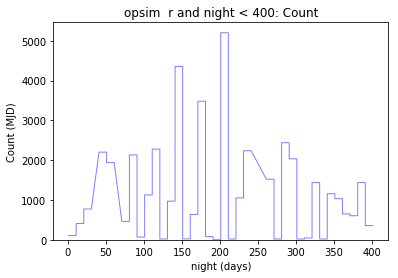

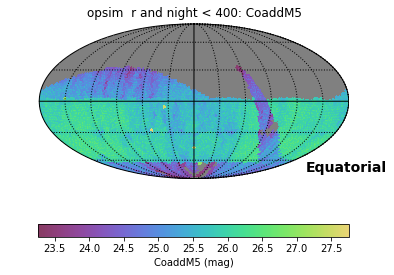

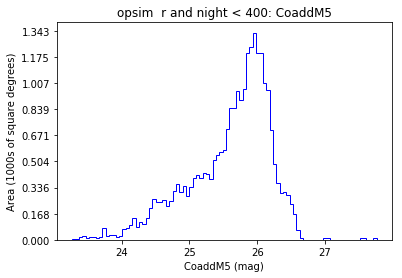

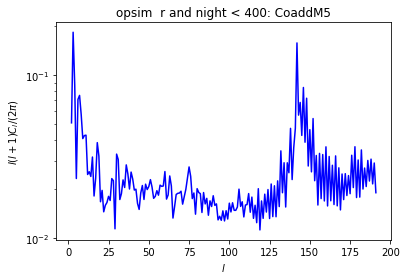

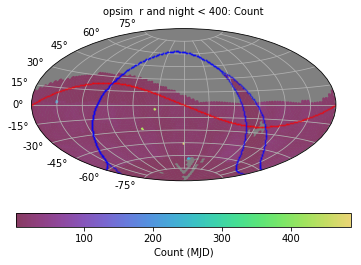

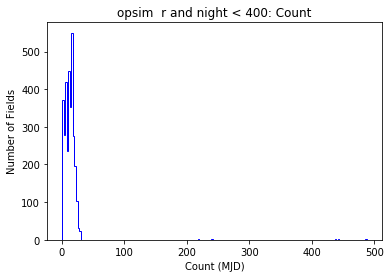

In [9]:
bgroup.runAll()
bgroup.plotAll(closefigs=False)

Let's examine the results from each slicer a bit further. 

In [10]:
print (bundles['uni'].metricValues)
bundles['uni'].plot()

[42366.0]


{}

With the UniSlicer, note the metric value matches the output (number of visits) from when we executed bgroup.runAll().  Since the UniSlicer only computes a single value, the plot method returns nothing.

---

[-- 110.0 409.0 774.0 -- 2202.0 1940.0 -- 462.0 2132.0 70.0 1127.0 2278.0
 20.0 970.0 4355.0 23.0 638.0 3481.0 80.0 2.0 5202.0 20.0 1053.0 2238.0 --
 -- 1521.0 20.0 2440.0 2035.0 20.0 46.0 1438.0 20.0 1157.0 1033.0 650.0
 605.0 1438.0 357.0 --]


{'BinnedData': 1}

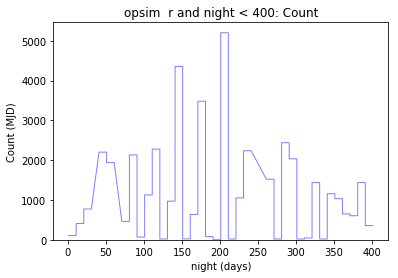

In [11]:
print (bundles['oneD'].metricValues)
bundles['oneD'].plot()

With the OneDSlicer, we binned on the 'night' value in opsim, and counted how many visits we had in each bin. The metric values show how many visits were in each bin, and the plot method produces a plot of the metric results as a function of the slicer bin values.

---

[-- -- -- ..., -- -- --]
monopole: 25.495  dipole: lon: -174.463, lat: -52.354, amp: 0.368187


{'Histogram': 2, 'PowerSpectrum': 3, 'SkyMap': 1}

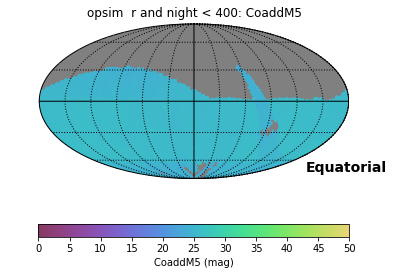

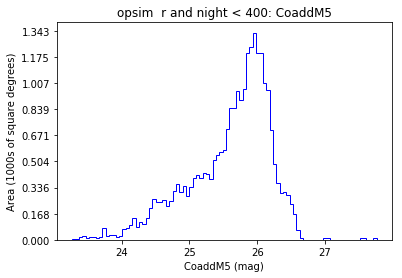

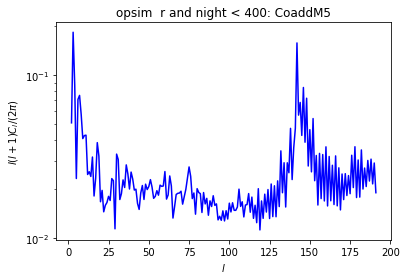

In [12]:
print (bundles['healpix'].metricValues)
bundles['healpix'].setPlotDict({'colorMin':0, 'colorMax':50})
bundles['healpix'].plot()

With the HealpixSlicer, we calculate the number of visits at each point in the Healpix grid, so we have a long metric data array. We also have three ways to visualize the data; the skymap, a histogram (scaled by the area of each healpixel), and the angular power spectrum of the metric values. 

---